In [2]:
from pathlib import Path
from nuclei.coco_exporter import *
from nuclei.imports import *
from nuclei.labelbox_utils import *
import pandas as pd
import json

root_dir = Path('../../').absolute()

from IPython.core.display import display, HTML

Successfully loaded API key: eyJhbGciOi...


In [3]:
#export
from nuclei.imports import *
from nuclei.labelbox_utils import *

In [4]:
project_names = ['IVT_CS', 'IVT_LB', 'IVT_LG', 'IVT_JS', 'IVT_KF']

## IF you need to re-download annotations, run this cell:

In [5]:
annotations = []
for project_name in progress_bar(project_names):
    project_pts = get_project(project_name)
    lbl_json, exp_path = get_project_labels(project_pts)
    annotations.append(lbl_json)

#### Load a json file which was downloaded previously 

In [5]:
def load_file(fn): 
    with open(fn, 'r') as f: 
        return json.load(f)
json_files = [Path(f'../../data/meta/{pn}_lbls.json') for pn in project_names]
annotations = [load_file(fn) for fn in json_files]

In [23]:
from collections import defaultdict, Counter

In [7]:
def json2map(row_data):
    return {
        'url': row_data['Labeled Data'],
        'dataset': row_data['Dataset Name'],
        row_data['Project Name'] : row_data['Label']
    }

In [8]:
labelmap = defaultdict(dict)
for annotation in annotations:
    for row in annotation:
        rowid = row['DataRow ID']
        labelmap[rowid].update(json2map(row))

### Inspect one image (update idx no. below)

In [9]:
color_map = {
    'Macrophage': 'cyan',
    'Monocyte': 'blue',
    'Neutrophil': 'red',
    'Eosinophil': 'orange',
    'Lymphocyte': 'green',
    'Epithelial cell': 'magenta',
    'Unknown cell': 'purple'
}

In [10]:
# ms = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
ms = ('1', 'x', '|', '_', '.')
marker_map = dict(zip(project_names, ms)); marker_map

{'IVT_CS': '1', 'IVT_LB': 'x', 'IVT_LG': '|', 'IVT_JS': '_', 'IVT_KF': '.'}

In [30]:
handles, labels = ctx.get_legend_handles_labels()
Counter(labels)

Counter({'Macrophage (IVT_CS)': 9,
         'Monocyte (IVT_CS)': 2,
         'Eosinophil (IVT_CS)': 3,
         'Lymphocyte (IVT_CS)': 4,
         'Unknown cell (IVT_CS)': 5,
         'Macrophage (IVT_LB)': 2,
         'Monocyte (IVT_LB)': 10,
         'Neutrophil (IVT_LB)': 3,
         'Lymphocyte (IVT_LB)': 1,
         'Unknown cell (IVT_LB)': 7,
         'Macrophage (IVT_LG)': 6,
         'Monocyte (IVT_LG)': 3,
         'Neutrophil (IVT_LG)': 2,
         'Eosinophil (IVT_LG)': 1,
         'Lymphocyte (IVT_LG)': 1,
         'Unknown cell (IVT_LG)': 3,
         'Macrophage (IVT_JS)': 14,
         'Monocyte (IVT_JS)': 1,
         'Neutrophil (IVT_JS)': 1,
         'Eosinophil (IVT_JS)': 2})

In [48]:
def sorted_labels(handles, labels):
    label_counts = Counter(labels)
    labels, handles = zip(*sorted(dict(zip(labels, handles)).items()))
    labels = [f'{k}: {label_counts[k]}' for k in labels]
    return handles, labels

In [49]:
from matplotlib.markers import MarkerStyle

## Thin lines

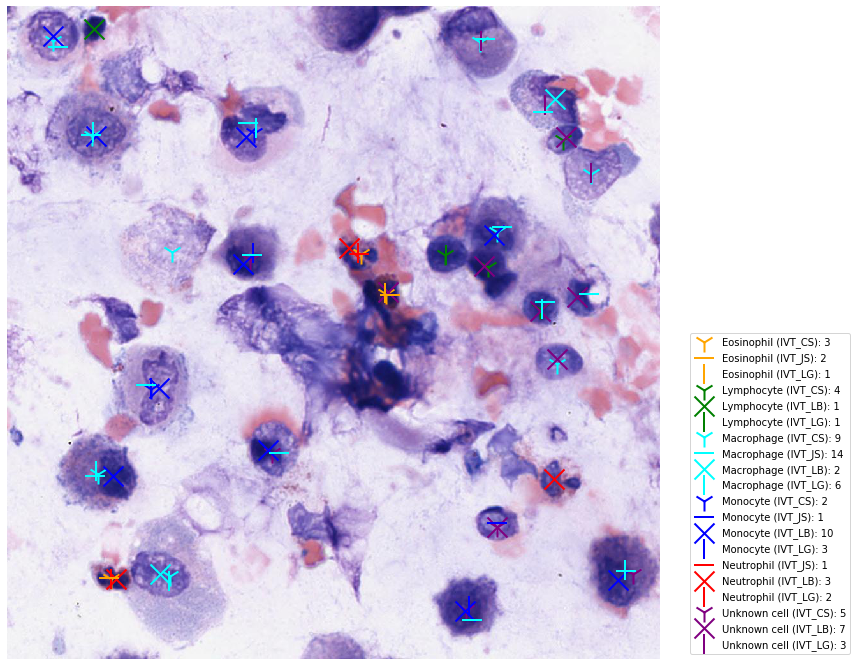

In [51]:
ms = ('1', 'x', '|', '_', '.')
marker_map = dict(zip(project_names, ms)); marker_map
def plot_image(label_row):
    img = img_from_url(label_row['url'])
    ctx = img.show(figsize=(12,12))
    for pname in progress_bar(project_names):
        if pname not in label_row: continue
        lbl = label_row[pname]
        for cls,pts in lbl.items():
            for pt in pts:
                x = pt['geometry']['x']
                y = pt['geometry']['y']
                tpoint = TensorPoint.create(np.array((x, y)))
                tpoint.show(ctx=ctx, 
                            c=color_map[cls], linewidth=2,
                            marker=marker_map[pname], s=400, label=f'{cls} ({pname})')
    handles, labels = ctx.get_legend_handles_labels()
    handles, labels = sorted_labels(handles, labels)
    ctx.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.3,0))
    return ctx
label_row = list(labelmap.values())[0]
ctx = plot_image(label_row)

## Solid shapes

In [52]:
marker_map

{'IVT_CS': '1', 'IVT_LB': 'x', 'IVT_LG': '|', 'IVT_JS': '_', 'IVT_KF': '.'}

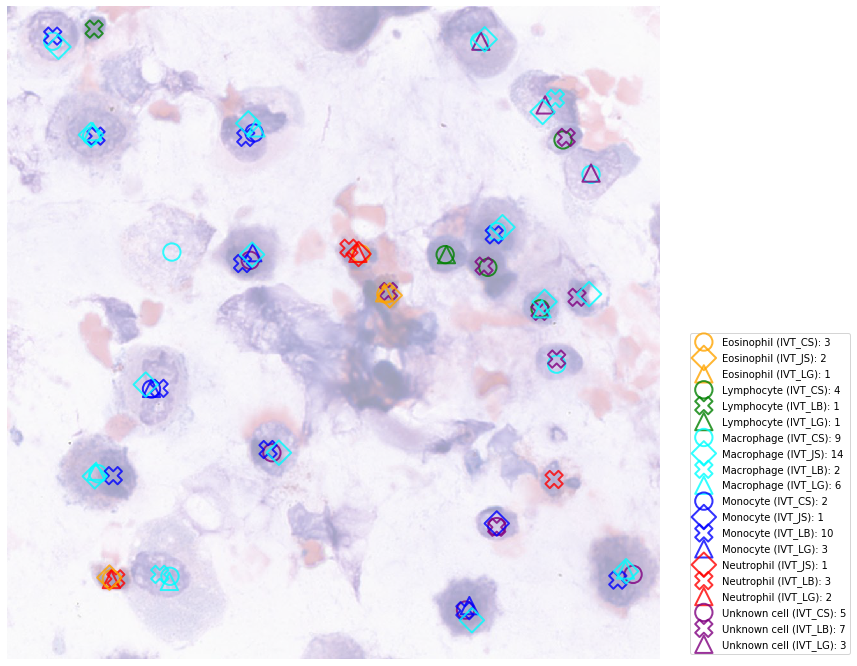

In [53]:
ms = ('o', 'X', '^', 'D', '*')
marker_map = dict(zip(project_names, ms)); marker_map

image_alpha = 0.4 # change this to dim the image
def plot_image(label_row):
    img = img_from_url(label_row['url'])
    ctx = img.show(figsize=(12,12), alpha=image_alpha)
    for pname in progress_bar(project_names):
        if pname not in label_row: continue
        lbl = label_row[pname]
        for cls,pts in lbl.items():
            for pt in pts:
                x = pt['geometry']['x']
                y = pt['geometry']['y']
                tpoint = TensorPoint.create(np.array((x, y)))
                tpoint.show(ctx=ctx, 
                            c='none', edgecolors=[color_map[cls]], linewidth=2, alpha=0.8,
                            marker=marker_map[pname], s=300, label=f'{cls} ({pname})')
    handles, labels = ctx.get_legend_handles_labels()
    handles, labels = sorted_labels(handles, labels)
    ctx.legend(handles, labels, loc='lower right', bbox_to_anchor=(1.3,0))
    return ctx
label_row = list(labelmap.values())[0]
ctx = plot_image(label_row)